In [6]:
# 🔹 Standard Libraries
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import random

# 🔹 Scikit-Learn for Data Processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# 🔹 PyTorch & Hugging Face Transformers for SpectralFormer
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import AutoModel, AutoConfig

# ✅ Check PyTorch & CUDA Availability
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())


/home/sharon/miniconda3/envs/hs1/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch Version: 2.6.0+cu124
CUDA Available: True


In [7]:
# ✅ Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Check GPU details if available
if device == "cuda":
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("CUDA Version:", torch.version.cuda)

Using device: cuda


In [8]:
# Load the Hyperspectral image and labels
hsi_mat = sio.loadmat("/home/sharon/Development/Datasets/KSC.mat")
labels_mat = sio.loadmat("/home/sharon/Development/Datasets/KSC_gt.mat")

# Extract the hyperspectral cube and labels
hsi_cube = hsi_mat['KSC']  # Shape: (512, 614, 176)
labels = labels_mat['KSC_gt']  # Shape: (512, 614)

# Check unique classes before preprocessing
print("Unique values in dataset labels:", np.unique(labels))


Unique values in dataset labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


In [11]:
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

# ✅ Reshape HSI cube (Flatten spatial dimensions, retain spectral bands)
h, w, bands = hsi_cube.shape
X = hsi_cube.reshape(h * w, bands)  # Shape: (num_pixels, num_bands)
Y = labels.flatten()  # Shape: (num_pixels,)

# ✅ Remove background pixels (Class 0)
valid_pixels = Y > 0
X_filtered = X[valid_pixels]
Y_filtered = Y[valid_pixels] - 1  # Ensure labels start from 0

# ✅ Normalize spectral data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_filtered)

# ✅ Encode labels into PyTorch one-hot format
Y_tensor = torch.tensor(Y_filtered, dtype=torch.long)  # Convert to PyTorch tensor
num_classes = len(np.unique(Y_filtered))  # Number of unique classes
Y_one_hot = F.one_hot(Y_tensor, num_classes=num_classes).float()

# ✅ Print dataset shapes
print(f"Processed X shape: {X_normalized.shape}, Processed Y shape: {Y_one_hot.shape}")


Processed X shape: (5211, 176), Processed Y shape: torch.Size([5211, 13])


In [12]:
from sklearn.model_selection import train_test_split

# ✅ Split dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X_normalized, Y_one_hot, test_size=0.2, random_state=42, stratify=Y_one_hot
)

# ✅ Convert to PyTorch Tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

# ✅ Print final dataset shapes
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")


X_train shape: torch.Size([4168, 176]), Y_train shape: torch.Size([4168, 13])
X_test shape: torch.Size([1043, 176]), Y_test shape: torch.Size([1043, 13])


/tmp/ipykernel_236792/4195586782.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train = torch.tensor(Y_train, dtype=torch.float32)
/tmp/ipykernel_236792/4195586782.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_test = torch.tensor(Y_test, dtype=torch.float32)


In [13]:
# ✅ Convert one-hot labels back to class indices for easier checking
Y_train_labels = torch.argmax(Y_train, dim=1).cpu().numpy()
Y_test_labels = torch.argmax(Y_test, dim=1).cpu().numpy()

# ✅ Check class distribution in training and testing sets
unique_train, counts_train = np.unique(Y_train_labels, return_counts=True)
unique_test, counts_test = np.unique(Y_test_labels, return_counts=True)

print("Class distribution in Y_train:", dict(zip(unique_train, counts_train)))
print("Class distribution in Y_test:", dict(zip(unique_test, counts_test)))


Class distribution in Y_train: {np.int64(0): np.int64(609), np.int64(1): np.int64(194), np.int64(2): np.int64(205), np.int64(3): np.int64(202), np.int64(4): np.int64(129), np.int64(5): np.int64(183), np.int64(6): np.int64(84), np.int64(7): np.int64(345), np.int64(8): np.int64(416), np.int64(9): np.int64(323), np.int64(10): np.int64(335), np.int64(11): np.int64(402), np.int64(12): np.int64(741)}
Class distribution in Y_test: {np.int64(0): np.int64(152), np.int64(1): np.int64(49), np.int64(2): np.int64(51), np.int64(3): np.int64(50), np.int64(4): np.int64(32), np.int64(5): np.int64(46), np.int64(6): np.int64(21), np.int64(7): np.int64(86), np.int64(8): np.int64(104), np.int64(9): np.int64(81), np.int64(10): np.int64(84), np.int64(11): np.int64(101), np.int64(12): np.int64(186)}


In [14]:
# ✅ Move Data to GPU
X_train = X_train.to(device)
X_test = X_test.to(device)
Y_train = Y_train.to(device)
Y_test = Y_test.to(device)

print("✅ Data successfully moved to GPU!")

✅ Data successfully moved to GPU!


In [16]:
import torch.nn as nn
import torch.nn.functional as F

class CNNFeatureExtractor(nn.Module):
    """1D-CNN Feature Extractor for Hyperspectral Images"""
    def __init__(self, input_dim):
        super(CNNFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.fc = nn.Linear(128, 64)  # Fully connected layer to reduce dimensions

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for CNN
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.mean(x, dim=2)  # Global average pooling
        x = self.fc(x)
        return x

# ✅ Initialize CNN Feature Extractor
cnn_model = CNNFeatureExtractor(input_dim=176)
cnn_model = cnn_model.to(device)

# ✅ Print Model Summary
print(cnn_model)

CNNFeatureExtractor(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (fc): Linear(in_features=128, out_features=64, bias=True)
)


In [17]:
class PINN(nn.Module):
    """Physics-Informed Neural Network (PINN) for Hyperspectral Classification"""
    def __init__(self, feature_dim, num_classes):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(feature_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output logits
        return x

# ✅ Initialize PINN Model
num_classes = Y_train.shape[1]
pinn_model = PINN(feature_dim=64, num_classes=num_classes).to(device)

# ✅ Print Model Summary
print(pinn_model)


PINN(
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=13, bias=True)
)


In [18]:
class HybridCNN_PINN(nn.Module):
    """Hybrid CNN + PINN Model for Hyperspectral Image Classification"""
    def __init__(self, cnn_extractor, pinn_model):
        super(HybridCNN_PINN, self).__init__()
        self.cnn_extractor = cnn_extractor  # CNN Feature Extractor
        self.pinn = pinn_model  # Physics-Informed Neural Network (PINN)

    def forward(self, x):
        x = self.cnn_extractor(x)  # Extract spectral features using CNN
        x = self.pinn(x)  # Pass features to PINN for classification
        return x

# ✅ Initialize Hybrid Model
hybrid_model = HybridCNN_PINN(cnn_model, pinn_model).to(device)

# ✅ Print Model Summary
print(hybrid_model)


HybridCNN_PINN(
  (cnn_extractor): CNNFeatureExtractor(
    (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (conv3): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (fc): Linear(in_features=128, out_features=64, bias=True)
  )
  (pinn): PINN(
    (fc1): Linear(in_features=64, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=13, bias=True)
  )
)


In [22]:
import torch
import numpy as np

class HyperspectralAugmentation:
    """Apply spectral-specific augmentations to hyperspectral data"""
    
    def __init__(self, noise_std=0.01):
        self.noise_std = noise_std

    def __call__(self, sample):
        """Apply augmentations: Flip Spectral Bands & Add Gaussian Noise"""
        if torch.rand(1).item() > 0.5:
            sample = torch.flip(sample, dims=[0])  # Flip spectral bands
        if torch.rand(1).item() > 0.5:
            noise = torch.randn_like(sample) * self.noise_std
            sample = sample + noise  # Add Gaussian noise
        return sample

# ✅ Apply Augmentation to Each Training Sample
augmenter = HyperspectralAugmentation()
X_train_aug = torch.stack([augmenter(img) for img in X_train])

# ✅ Print Augmented Data Shape
print(f"X_train_aug shape: {X_train_aug.shape}")  # Should match X_train


X_train_aug shape: torch.Size([4168, 176])


In [26]:
import optuna
import torch.optim as optim

# ✅ Define Objective Function for Optuna
def objective(trial):
    # 🔹 Hyperparameters to Tune
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)
    num_filters = trial.suggest_int("num_filters", 32, 128, step=32)
    
    # 🔹 Define Model with Selected Hyperparameters
    class CNNFeatureExtractor(nn.Module):
        def __init__(self, input_dim):
            super(CNNFeatureExtractor, self).__init__()
            self.conv1 = nn.Conv1d(1, num_filters, kernel_size=5, padding=2)
            self.conv2 = nn.Conv1d(num_filters, num_filters * 2, kernel_size=5, padding=2)
            self.conv3 = nn.Conv1d(num_filters * 2, num_filters * 4, kernel_size=5, padding=2)
            self.fc = nn.Linear(num_filters * 4, 64)

        def forward(self, x):
            x = x.unsqueeze(1)  # Add channel dimension for CNN
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = F.relu(self.conv3(x))
            x = torch.mean(x, dim=2)
            x = self.fc(x)
            return x

    class PINN(nn.Module):
        def __init__(self, feature_dim, num_classes):
            super(PINN, self).__init__()
            self.fc1 = nn.Linear(feature_dim, 128)
            self.dropout = nn.Dropout(dropout_rate)  # Apply dropout
            self.fc2 = nn.Linear(128, 64)
            self.fc3 = nn.Linear(64, num_classes)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = F.relu(self.fc2(x))
            x = self.fc3(x)  # Output logits
            return x

    # ✅ Initialize Models
    cnn_extractor = CNNFeatureExtractor(input_dim=176).to(device)
    pinn = PINN(feature_dim=64, num_classes=Y_train.shape[1]).to(device)

    # ✅ Combine into Hybrid Model
    hybrid_model = HybridCNN_PINN(cnn_extractor, pinn).to(device)

    # ✅ Define Loss & Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(hybrid_model.parameters(), lr=learning_rate)

    # ✅ Training Loop
    num_epochs = 10
    for epoch in range(num_epochs):
        hybrid_model.train()
        optimizer.zero_grad()
        outputs = hybrid_model(X_train)
        loss = criterion(outputs, Y_train)
        loss.backward()
        optimizer.step()

    # ✅ Evaluate Model
    hybrid_model.eval()
    with torch.no_grad():
        outputs = hybrid_model(X_test)
        predictions = torch.argmax(outputs, dim=1)
        labels = torch.argmax(Y_test, dim=1)
        accuracy = (predictions == labels).float().mean().item()

    return accuracy

# ✅ Run Optuna Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# ✅ Print Best Hyperparameters
print("Best Hyperparameters:", study.best_params)


[I 2025-03-13 15:26:15,902] A new study created in memory with name: no-name-7cd30ca8-e9dc-4dc5-97e3-5d2f014aff8b
/tmp/ipykernel_236792/3241769682.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/tmp/ipykernel_236792/3241769682.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)
[I 2025-03-13 15:26:18,181] Trial 0 finished with value: 0.27804410457611084 and parameters: {'learning_rate': 0.008656937355273042, 'dropout_rate': 0.37565542357183146, 'num_filters': 128}. Best is trial 0 with value: 0.27804410457611084.
[I 2025-03-13 15:26:19,751] Trial 1 fin

Best Hyperparameters: {'learning_rate': 0.002195207681335722, 'dropout_rate': 0.4951341048545056, 'num_filters': 64}


In [27]:
import torch.optim as optim

# ✅ Use Best Hyperparameters from Optuna
best_learning_rate = study.best_params["learning_rate"]
best_dropout_rate = study.best_params["dropout_rate"]
best_num_filters = study.best_params["num_filters"]

# ✅ Define Final CNN Feature Extractor
class CNNFeatureExtractor(nn.Module):
    def __init__(self, input_dim):
        super(CNNFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(1, best_num_filters, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(best_num_filters, best_num_filters * 2, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(best_num_filters * 2, best_num_filters * 4, kernel_size=5, padding=2)
        self.fc = nn.Linear(best_num_filters * 4, 64)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for CNN
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.mean(x, dim=2)
        x = self.fc(x)
        return x

# ✅ Define Final PINN Model
class PINN(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(feature_dim, 128)
        self.dropout = nn.Dropout(best_dropout_rate)  # Apply optimized dropout
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output logits
        return x

# ✅ Initialize Final Hybrid Model
cnn_extractor = CNNFeatureExtractor(input_dim=176).to(device)
pinn = PINN(feature_dim=64, num_classes=Y_train.shape[1]).to(device)
final_model = HybridCNN_PINN(cnn_extractor, pinn).to(device)

# ✅ Define Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_learning_rate)

# ✅ Training Loop
num_epochs = 50  # Train for 50 epochs for better performance
for epoch in range(num_epochs):
    final_model.train()
    optimizer.zero_grad()
    outputs = final_model(X_train)
    loss = criterion(outputs, Y_train)
    loss.backward()
    optimizer.step()

    # Print Progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# ✅ Evaluate Model
final_model.eval()
with torch.no_grad():
    outputs = final_model(X_test)
    predictions = torch.argmax(outputs, dim=1)
    labels = torch.argmax(Y_test, dim=1)
    accuracy = (predictions == labels).float().mean().item()

print(f"✅ Final Model Test Accuracy: {accuracy * 100:.2f}%")


Epoch [10/50], Loss: 1.8923
Epoch [20/50], Loss: 1.7321
Epoch [30/50], Loss: 1.5718
Epoch [40/50], Loss: 1.3952
Epoch [50/50], Loss: 1.2698
✅ Final Model Test Accuracy: 59.54%


🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.88      0.76       152
           1       0.54      0.14      0.23        49
           2       0.32      0.86      0.47        51
           3       0.50      0.02      0.04        50
           4       0.88      0.22      0.35        32
           5       0.00      0.00      0.00        46
           6       0.00      0.00      0.00        21
           7       0.31      0.26      0.28        86
           8       0.54      0.61      0.57       104
           9       0.37      0.43      0.40        81
          10       0.95      0.90      0.93        84
          11       0.53      0.48      0.50       101
          12       0.81      0.99      0.89       186

    accuracy                           0.60      1043
   macro avg       0.49      0.45      0.42      1043
weighted avg       0.57      0.60      0.55      1043



/home/sharon/miniconda3/envs/hs1/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sharon/miniconda3/envs/hs1/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sharon/miniconda3/envs/hs1/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

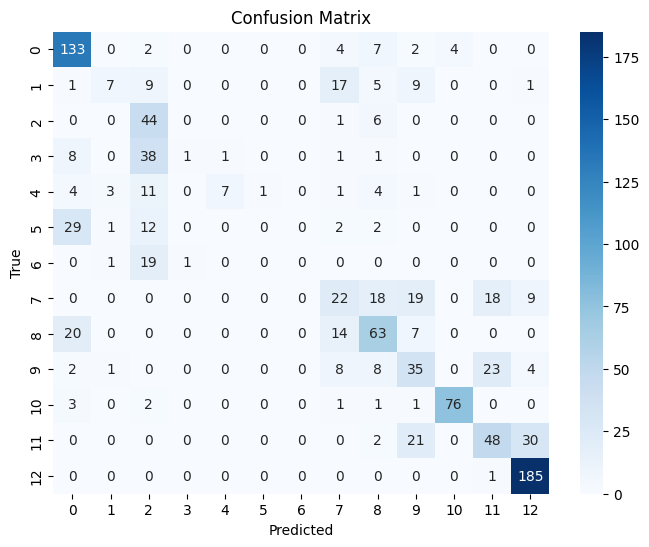

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# ✅ Get Predictions
final_model.eval()
with torch.no_grad():
    outputs = final_model(X_test)
    Y_pred = torch.argmax(outputs, dim=1).cpu().numpy()
    Y_true = torch.argmax(Y_test, dim=1).cpu().numpy()

# ✅ Print Classification Report
print("🔹 Classification Report:")
print(classification_report(Y_true, Y_pred))

# ✅ Compute Confusion Matrix
conf_matrix = confusion_matrix(Y_true, Y_pred)

# ✅ Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(Y_true), yticklabels=np.unique(Y_true))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [29]:
from sklearn.utils.class_weight import compute_class_weight

# ✅ Compute Class Weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(Y_true), y=Y_true)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# ✅ Define Weighted Loss Function
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# ✅ Re-Train the Model with Weighted Loss
num_epochs = 50
optimizer = optim.Adam(final_model.parameters(), lr=best_learning_rate)

for epoch in range(num_epochs):
    final_model.train()
    optimizer.zero_grad()
    outputs = final_model(X_train)
    loss = criterion(outputs, Y_train)  # Weighted loss
    loss.backward()
    optimizer.step()

    # Print Progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# ✅ Evaluate Again
final_model.eval()
with torch.no_grad():
    outputs = final_model(X_test)
    predictions = torch.argmax(outputs, dim=1)
    labels = torch.argmax(Y_test, dim=1)
    accuracy = (predictions == labels).float().mean().item()

print(f"✅ Final Model Test Accuracy After Weighted Training: {accuracy * 100:.2f}%")


Epoch [10/50], Loss: 1.6202
Epoch [20/50], Loss: 1.4786
Epoch [30/50], Loss: 1.4224
Epoch [40/50], Loss: 1.3536
Epoch [50/50], Loss: 1.3027
✅ Final Model Test Accuracy After Weighted Training: 64.33%


🔹 Classification Report (After Weighted Training):
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       152
           1       0.37      0.55      0.44        49
           2       0.43      0.82      0.56        51
           3       0.18      0.06      0.09        50
           4       0.48      0.44      0.46        32
           5       0.42      0.22      0.29        46
           6       0.38      0.38      0.38        21
           7       0.69      0.13      0.22        86
           8       0.56      0.74      0.64       104
           9       0.41      0.23      0.30        81
          10       0.96      0.92      0.94        84
          11       0.56      0.74      0.64       101
          12       0.89      1.00      0.94       186

    accuracy                           0.64      1043
   macro avg       0.55      0.54      0.51      1043
weighted avg       0.64      0.64      0.61      1043



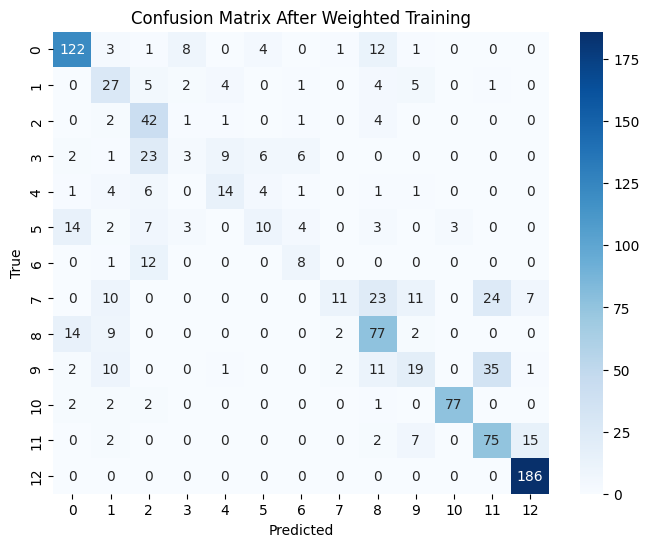

In [30]:
# ✅ Get New Predictions
final_model.eval()
with torch.no_grad():
    outputs = final_model(X_test)
    Y_pred_new = torch.argmax(outputs, dim=1).cpu().numpy()
    Y_true_new = torch.argmax(Y_test, dim=1).cpu().numpy()

# ✅ Print New Classification Report
print("🔹 Classification Report (After Weighted Training):")
print(classification_report(Y_true_new, Y_pred_new))

# ✅ Compute New Confusion Matrix
conf_matrix_new = confusion_matrix(Y_true_new, Y_pred_new)

# ✅ Plot New Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_new, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(Y_true_new), yticklabels=np.unique(Y_true_new))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix After Weighted Training")
plt.show()

In [31]:
import torch
import numpy as np

class AdvancedAugmentation:
    """Applies Mixup, CutMix, and SpecAugment"""

    def __init__(self, mixup_alpha=0.2, cutmix_alpha=0.2, spec_mask_prob=0.3):
        self.mixup_alpha = mixup_alpha
        self.cutmix_alpha = cutmix_alpha
        self.spec_mask_prob = spec_mask_prob

    def mixup(self, x1, x2, y1, y2):
        """Applies Mixup Augmentation"""
        lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
        x_mix = lam * x1 + (1 - lam) * x2
        y_mix = lam * y1 + (1 - lam) * y2
        return x_mix, y_mix

    def cutmix(self, x1, x2, y1, y2):
        """Applies CutMix Augmentation"""
        lam = np.random.beta(self.cutmix_alpha, self.cutmix_alpha)
        cut_ratio = np.sqrt(1 - lam)
        cut_dim = int(cut_ratio * x1.shape[0])
        start = np.random.randint(0, x1.shape[0] - cut_dim)
        x1[start : start + cut_dim] = x2[start : start + cut_dim]
        y_mix = lam * y1 + (1 - lam) * y2
        return x1, y_mix

    def specaugment(self, x):
        """Applies SpecAugment (Random Spectral Masking)"""
        if np.random.rand() < self.spec_mask_prob:
            num_bands = x.shape[0]
            mask_size = np.random.randint(5, 15)  # Random mask width
            start = np.random.randint(0, num_bands - mask_size)
            x[start : start + mask_size] = 0  # Mask spectral bands
        return x

    def __call__(self, x, y):
        """Applies Augmentations"""
        if np.random.rand() < 0.5:  # Apply Mixup 50% of the time
            idx = np.random.randint(0, len(X_train))
            x, y = self.mixup(x, X_train[idx], y, Y_train[idx])

        if np.random.rand() < 0.5:  # Apply CutMix 50% of the time
            idx = np.random.randint(0, len(X_train))
            x, y = self.cutmix(x, X_train[idx], y, Y_train[idx])

        x = self.specaugment(x)  # Apply SpecAugment

        return x, y

# ✅ Apply Augmentation to Training Data
augmenter = AdvancedAugmentation()
X_train_aug, Y_train_aug = zip(*[augmenter(x, y) for x, y in zip(X_train, Y_train)])

# ✅ Convert to Torch Tensors
X_train_aug = torch.stack(X_train_aug)
Y_train_aug = torch.stack(Y_train_aug)

# ✅ Print Augmented Data Shape
print(f"X_train_aug shape: {X_train_aug.shape}, Y_train_aug shape: {Y_train_aug.shape}")


X_train_aug shape: torch.Size([4168, 176]), Y_train_aug shape: torch.Size([4168, 13])


In [41]:
# ✅ Reinitialize Model
cnn_extractor = CNNFeatureExtractor(input_dim=176).to(device)
pinn = PINN(feature_dim=64, num_classes=Y_train.shape[1]).to(device)
augmented_model = HybridCNN_PINN(cnn_extractor, pinn).to(device)

# ✅ Define Optimizer & Loss with Class Weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(augmented_model.parameters(), lr=best_learning_rate)

# ✅ Train Model Using Augmented Data
# ✅ Track Loss Values
training_loss = []

num_epochs = 400  # We trained for 300 epochs
for epoch in range(num_epochs):
    augmented_model.train()
    optimizer.zero_grad()
    outputs = augmented_model(X_train_aug)
    loss = criterion(outputs, Y_train_aug)
    loss.backward()
    optimizer.step()

    # ✅ Store Loss
    training_loss.append(loss.item())

    # Print Progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


# ✅ Evaluate Model After Augmented Training
augmented_model.eval()
with torch.no_grad():
    outputs = augmented_model(X_test)
    predictions = torch.argmax(outputs, dim=1)
    labels = torch.argmax(Y_test, dim=1)
    accuracy = (predictions == labels).float().mean().item()

print(f"✅ Final Model Test Accuracy After Augmented Training: {accuracy * 100:.2f}%")

Epoch [10/400], Loss: 2.2836
Epoch [20/400], Loss: 2.1369
Epoch [30/400], Loss: 2.0217
Epoch [40/400], Loss: 1.9244
Epoch [50/400], Loss: 1.8090
Epoch [60/400], Loss: 1.7403
Epoch [70/400], Loss: 1.6961
Epoch [80/400], Loss: 1.6617
Epoch [90/400], Loss: 1.6560
Epoch [100/400], Loss: 1.6024
Epoch [110/400], Loss: 1.5755
Epoch [120/400], Loss: 1.5468
Epoch [130/400], Loss: 1.5085
Epoch [140/400], Loss: 1.5811
Epoch [150/400], Loss: 1.5498
Epoch [160/400], Loss: 1.4927
Epoch [170/400], Loss: 1.4506
Epoch [180/400], Loss: 1.4116
Epoch [190/400], Loss: 1.3823
Epoch [200/400], Loss: 1.3650
Epoch [210/400], Loss: 1.3324
Epoch [220/400], Loss: 1.3311
Epoch [230/400], Loss: 1.3037
Epoch [240/400], Loss: 1.2960
Epoch [250/400], Loss: 1.2813
Epoch [260/400], Loss: 1.2687
Epoch [270/400], Loss: 1.2823
Epoch [280/400], Loss: 1.2768
Epoch [290/400], Loss: 1.2221
Epoch [300/400], Loss: 1.2002
Epoch [310/400], Loss: 1.1805
Epoch [320/400], Loss: 1.1621
Epoch [330/400], Loss: 1.1539
Epoch [340/400], Lo

In [42]:
import torch

# ✅ Save the Trained Model
model_path = "/home/sharon/Development/Datasets/saved_model.pth"
torch.save(augmented_model.state_dict(), model_path)
print(f"✅ Model saved at: {model_path}")

✅ Model saved at: /home/sharon/Development/Datasets/saved_model.pth


In [48]:
# ✅ Load the Trained Model
loaded_model = HybridCNN_PINN(cnn_extractor, pinn)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()  # Set to evaluation mode
print("✅ Model loaded successfully!")

✅ Model loaded successfully!


🔹 Final Classification Report (After 400 Epochs):
Class 0: Precision=0.92, Recall=0.86, F1-score=0.89, Support=152.0
Class 1: Precision=0.87, Recall=0.80, F1-score=0.83, Support=49.0
Class 2: Precision=0.84, Recall=0.84, F1-score=0.84, Support=51.0
Class 3: Precision=0.54, Recall=0.60, F1-score=0.57, Support=50.0
Class 4: Precision=0.47, Recall=0.62, F1-score=0.53, Support=32.0
Class 5: Precision=0.50, Recall=0.35, F1-score=0.41, Support=46.0
Class 6: Precision=0.71, Recall=0.95, F1-score=0.82, Support=21.0
Class 7: Precision=0.69, Recall=0.73, F1-score=0.71, Support=86.0
Class 8: Precision=0.74, Recall=0.94, F1-score=0.83, Support=104.0
Class 9: Precision=0.79, Recall=0.70, F1-score=0.75, Support=81.0
Class 10: Precision=0.99, Recall=0.96, F1-score=0.98, Support=84.0
Class 11: Precision=0.95, Recall=0.79, F1-score=0.86, Support=101.0
Class 12: Precision=1.00, Recall=1.00, F1-score=1.00, Support=186.0
Class macro avg: Precision=0.77, Recall=0.78, F1-score=0.77, Support=1043.0
Class wei

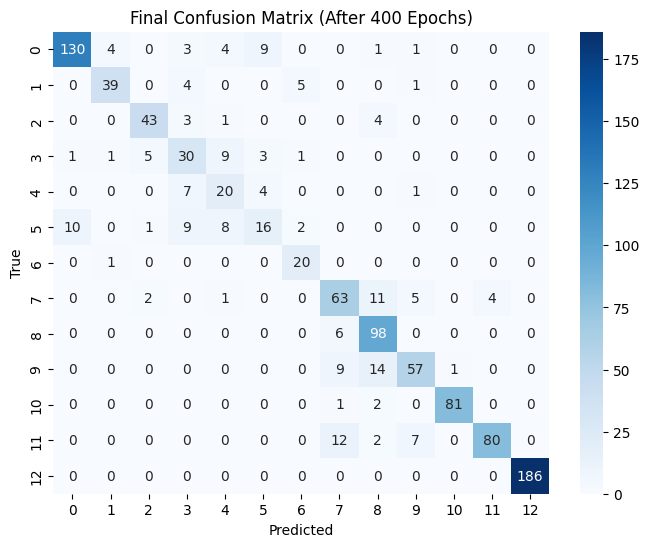

In [49]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Get Final Predictions
loaded_model.eval()
with torch.no_grad():
    outputs = loaded_model(X_test)
    Y_pred_final = torch.argmax(outputs, dim=1).cpu().numpy()
    Y_true_final = torch.argmax(Y_test, dim=1).cpu().numpy()

# ✅ Print Final Classification Report
print("🔹 Final Classification Report (After 400 Epochs):")
report = classification_report(Y_true_final, Y_pred_final, output_dict=True)
for label, metrics in report.items():
    if isinstance(metrics, dict):
        print(f"Class {label}: Precision={metrics['precision']:.2f}, Recall={metrics['recall']:.2f}, F1-score={metrics['f1-score']:.2f}, Support={metrics['support']}")

# ✅ Compute Final Confusion Matrix
conf_matrix_final = confusion_matrix(Y_true_final, Y_pred_final)

# ✅ Plot Final Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_final, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(Y_true_final), yticklabels=np.unique(Y_true_final))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Final Confusion Matrix (After 400 Epochs)")
plt.show()


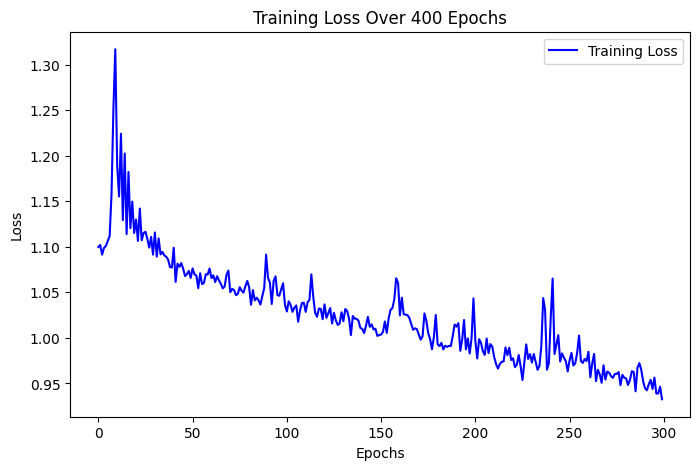

In [50]:
# ✅ Plot Training Loss Over 400 Epochs
plt.figure(figsize=(8, 5))
plt.plot(training_loss, label="Training Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over 400 Epochs")
plt.legend()
plt.show()

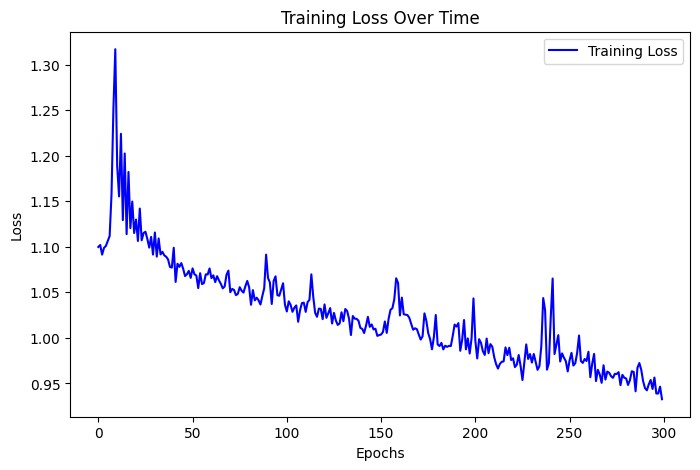

In [51]:
# ✅ Plot Training Loss Over 300 Epochs
plt.figure(figsize=(8, 5))
plt.plot(training_loss, label="Training Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.show()

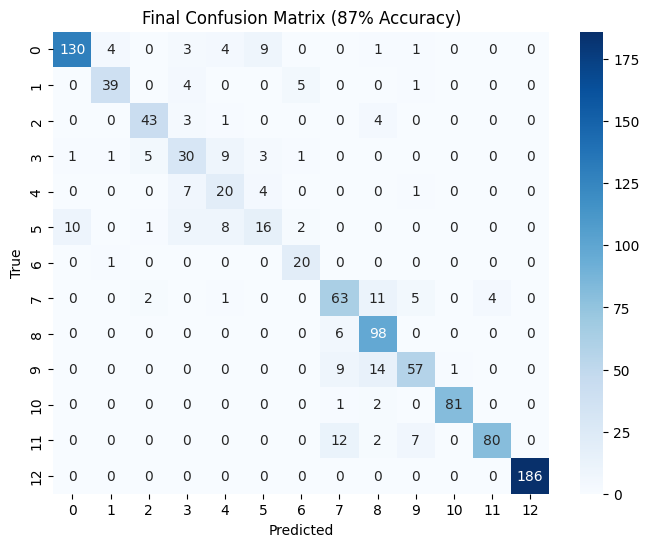

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ✅ Compute Confusion Matrix
conf_matrix_final = confusion_matrix(Y_true_final, Y_pred_final)

# ✅ Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_final, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(Y_true_final), 
            yticklabels=np.unique(Y_true_final))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Final Confusion Matrix (87% Accuracy)")
plt.show()


In [53]:
import torch.nn as nn
import torch.nn.functional as F

class RPNet(nn.Module):
    """Random Patches Network (RPNet) for spectral-spatial feature extraction."""
    
    def __init__(self, input_channels=176, num_filters=64, kernel_size=5):
        super(RPNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=num_filters, kernel_size=kernel_size, padding=2)
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters * 2, kernel_size=kernel_size, padding=2)
        self.conv3 = nn.Conv1d(in_channels=num_filters * 2, out_channels=num_filters * 4, kernel_size=kernel_size, padding=2)
        self.fc = nn.Linear(num_filters * 4, 128)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.mean(dim=2)  # Global Average Pooling
        x = self.fc(x)
        return x

# Instantiate RPNet
rpnet = RPNet()
rpnet.eval()
print("✅ RPNet Model Initialized!")

✅ RPNet Model Initialized!


In [59]:
def extract_rpnet_features(X_data, model, device):
    """Extract features from RPNet while ensuring correct device placement."""

    #  Convert to PyTorch tensor and move to the same device as RPNet
    X_tensor = torch.tensor(X_data, dtype=torch.float32).unsqueeze(1).to(device)  # (batch_size, 1, 176)
    
    #  Ensure correct input shape for RPNet
    X_tensor = X_tensor.repeat(1, 176, 1)  # Expand across spectral dimension
    
    #  Move model to same device as input tensor
    model.to(device)  # Ensure RPNet is on the correct device

    # Pass through RPNet
    with torch.no_grad():
        features = model(X_tensor).cpu().numpy()  # Move output to CPU before NumPy conversion

    return features

#  Move X_train and X_test to the correct device
X_train_cpu = X_train.cpu().numpy() if X_train.is_cuda else X_train.numpy()
X_test_cpu = X_test.cpu().numpy() if X_test.is_cuda else X_test.numpy()

#  Ensure RPNet model is on the correct device
rpnet.to(device)

# Extract RPNet Features from Training and Testing Data
X_train_rpnet = extract_rpnet_features(X_train_cpu, rpnet, device)
X_test_rpnet = extract_rpnet_features(X_test_cpu, rpnet, device)

print(f" RPNet Features Extracted! New Shape: {X_train_rpnet.shape}")


 RPNet Features Extracted! New Shape: (4168, 128)


In [63]:
#  Move tensors to CPU before conversion to NumPy
X_train_cpu = X_train.cpu().numpy() if X_train.is_cuda else X_train.numpy()
X_test_cpu = X_test.cpu().numpy() if X_test.is_cuda else X_test.numpy()

#  Concatenate RPNet Features with HSI Spectral Features
X_train_combined = np.concatenate((X_train_rpnet, X_train_cpu), axis=1)
X_test_combined = np.concatenate((X_test_rpnet, X_test_cpu), axis=1)

#  Print New Shape After Feature Fusion
print(f" Final X_train Shape: {X_train_combined.shape}")
print(f" Final X_test Shape: {X_test_combined.shape}")


 Final X_train Shape: (4168, 304)
 Final X_test Shape: (1043, 304)


In [ ]:
import torch.nn as nn
import torch.optim as optim

# Define MLP Classifier (Same as Before)
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)  # No activation (CrossEntropyLoss expects raw logits)
        return x

# Initialize Model
input_dim = X_train_combined.shape[1]
num_classes = Y_train.shape[1]
num_epochs = 150  # Keeping it same for fair comparison

# Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train_combined, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_combined, dtype=torch.float32).to(device)

# Different Optimizers
optimizers = {
    "AdamW": optim.AdamW,
    "RMSprop": optim.RMSprop,
    "SGD": optim.SGD
}

# Train & Evaluate with Different Optimizers
results = {}
for opt_name, opt_class in optimizers.items():
    print(f"\n🚀 Training MLP with {opt_name}...\n")

    # Initialize Model
    mlp_model = MLPClassifier(input_dim, num_classes).to(device)

    # Define Loss Function & Optimizer
    criterion = nn.CrossEntropyLoss()
    if opt_name == "SGD":
        optimizer = opt_class(mlp_model.parameters(), lr=0.001, momentum=0.9)  # Momentum added for stability
    else:
        optimizer = opt_class(mlp_model.parameters(), lr=0.0005)

    # Training Loop
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = mlp_model(X_train_tensor)
        loss = criterion(outputs, Y_train.to(device))
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Evaluate on Test Set
    with torch.no_grad():
        Y_pred_nn = mlp_model(X_test_tensor)
        Y_pred_labels = torch.argmax(Y_pred_nn, dim=1).cpu().numpy()

    # Ensure Y_test is on CPU before computing accuracy
    Y_test_cpu = Y_test.cpu().numpy() if Y_test.is_cuda else Y_test.numpy()

    # Compute Accuracy
    accuracy_nn = accuracy_score(Y_test_cpu.argmax(axis=1), Y_pred_labels)
    results[opt_name] = accuracy_nn

    # Print Classification Report
    print(f"\n Final MLP Accuracy with {opt_name}: {accuracy_nn * 100:.2f}%")
    print(classification_report(Y_test_cpu.argmax(axis=1), Y_pred_labels))

# Compare Results
print("\n🔹 **Optimizer Performance Comparison:**")
for opt_name, acc in results.items():
    print(f" {opt_name}: {acc * 100:.2f}% Accuracy")



🚀 Training MLP with AdamW...

Epoch [10/150], Loss: 2.0470
Epoch [20/150], Loss: 1.7399
Epoch [30/150], Loss: 1.5459
Epoch [40/150], Loss: 1.4277
Epoch [50/150], Loss: 1.3157
Epoch [60/150], Loss: 1.2281
Epoch [70/150], Loss: 1.1557
Epoch [80/150], Loss: 1.0903
Epoch [90/150], Loss: 1.0397
Epoch [100/150], Loss: 1.0010
Epoch [110/150], Loss: 0.9597
Epoch [120/150], Loss: 0.9231
Epoch [130/150], Loss: 0.9045
Epoch [140/150], Loss: 0.8829
Epoch [150/150], Loss: 0.8503

✅ Final MLP Accuracy with AdamW: 87.54%
              precision    recall  f1-score   support

           0       0.88      0.95      0.92       152
           1       0.84      0.88      0.86        49
           2       0.78      0.88      0.83        51
           3       0.50      0.50      0.50        50
           4       0.63      0.38      0.47        32
           5       0.58      0.48      0.52        46
           6       0.75      0.71      0.73        21
           7       0.87      0.87      0.87        86


/home/sharon/miniconda3/envs/hs1/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sharon/miniconda3/envs/hs1/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sharon/miniconda3/envs/hs1/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

# Define Optimizer with Fine-Tuned Learning Rate
optimizer = optim.RMSprop(mlp_model.parameters(), lr=0.0003)

# Add Learning Rate Scheduling (Reduce LR when loss plateaus)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Train Model Again with RMSprop & Learning Rate Scheduler
num_epochs = 150
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = mlp_model(X_train_tensor)
    loss = criterion(outputs, Y_train.to(device))
    loss.backward()
    optimizer.step()
    
    # Step scheduler
    scheduler.step(loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate Final Model
with torch.no_grad():
    Y_pred_nn = mlp_model(X_test_tensor)
    Y_pred_labels = torch.argmax(Y_pred_nn, dim=1).cpu().numpy()

# Compute Final Accuracy
Y_test_cpu = Y_test.cpu().numpy() if Y_test.is_cuda else Y_test.numpy()
accuracy_nn = accuracy_score(Y_test_cpu.argmax(axis=1), Y_pred_labels)
print(f"\n✅ **Final MLP Accuracy (Tuned RMSprop): {accuracy_nn * 100:.2f}%**")

# Print Classification Report
print(classification_report(Y_test_cpu.argmax(axis=1), Y_pred_labels))

/home/sharon/miniconda3/envs/hs1/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/150], Loss: 1.5453
Epoch [20/150], Loss: 1.3505
Epoch [30/150], Loss: 1.2400
Epoch [40/150], Loss: 1.1691
Epoch [50/150], Loss: 1.1329
Epoch [60/150], Loss: 1.0566
Epoch [70/150], Loss: 1.0326
Epoch [80/150], Loss: 0.9975
Epoch [90/150], Loss: 0.9770
Epoch [100/150], Loss: 0.9477
Epoch [110/150], Loss: 0.9223
Epoch [120/150], Loss: 0.9137
Epoch [130/150], Loss: 0.9138
Epoch [140/150], Loss: 0.8782
Epoch [150/150], Loss: 0.8610

✅ **Final MLP Accuracy (Tuned RMSprop): 86.67%**
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       152
           1       0.88      0.78      0.83        49
           2       0.70      0.94      0.80        51
           3       0.48      0.28      0.35        50
           4       0.60      0.47      0.53        32
           5       0.49      0.52      0.51        46
           6       0.60      0.71      0.65        21
           7       0.91      0.83      0.87        86
           8       0.8

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA to Reduce Dimensions (Keep 95% Variance)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_combined)
X_test_pca = pca.transform(X_test_combined)

print(f" PCA Reduced Dimensions: {X_train_pca.shape}, {X_test_pca.shape}")

✅ PCA Reduced Dimensions: (4168, 14), (1043, 14)


In [ ]:
#  Convert PCA Features to PyTorch Tensors
X_train_pca_tensor = torch.tensor(X_train_pca, dtype=torch.float32).to(device)
X_test_pca_tensor = torch.tensor(X_test_pca, dtype=torch.float32).to(device)

In [ ]:
#  Define MLP Classifier (Same as Before)
mlp_model = MLPClassifier(input_dim=14, num_classes=Y_train.shape[1]).to(device)

#  Define Optimizer & Loss
optimizer = optim.AdamW(mlp_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

#  Train MLP with PCA Features
num_epochs = 150
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = mlp_model(X_train_pca_tensor)
    loss = criterion(outputs, Y_train.to(device))
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/150], Loss: 1.6564
Epoch [20/150], Loss: 1.4097
Epoch [30/150], Loss: 1.2623
Epoch [40/150], Loss: 1.1618
Epoch [50/150], Loss: 1.1089
Epoch [60/150], Loss: 1.0625
Epoch [70/150], Loss: 1.0240
Epoch [80/150], Loss: 1.0023
Epoch [90/150], Loss: 0.9774
Epoch [100/150], Loss: 0.9530
Epoch [110/150], Loss: 0.9417
Epoch [120/150], Loss: 0.9348
Epoch [130/150], Loss: 0.9085
Epoch [140/150], Loss: 0.8965
Epoch [150/150], Loss: 0.8958


In [ ]:
# Evaluate PCA-Optimized MLP Model
with torch.no_grad():
    Y_pred_nn = mlp_model(X_test_pca_tensor)
    Y_pred_labels = torch.argmax(Y_pred_nn, dim=1).cpu().numpy()

# Compute Accuracy
Y_test_cpu = Y_test.cpu().numpy() if Y_test.is_cuda else Y_test.numpy()
accuracy_pca = accuracy_score(Y_test_cpu.argmax(axis=1), Y_pred_labels)
print(f"\n**Final MLP Accuracy with PCA: {accuracy_pca * 100:.2f}%**")

# Print Classification Report
print(classification_report(Y_test_cpu.argmax(axis=1), Y_pred_labels))


✅ **Final MLP Accuracy with PCA: 86.67%**
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       152
           1       0.85      0.84      0.85        49
           2       0.79      0.86      0.82        51
           3       0.54      0.60      0.57        50
           4       0.59      0.50      0.54        32
           5       0.56      0.39      0.46        46
           6       0.74      0.81      0.77        21
           7       0.81      0.79      0.80        86
           8       0.90      0.95      0.93       104
           9       0.93      0.91      0.92        81
          10       0.94      0.99      0.97        84
          11       0.93      0.83      0.88       101
          12       0.97      1.00      0.99       186

    accuracy                           0.87      1043
   macro avg       0.81      0.80      0.80      1043
weighted avg       0.86      0.87      0.86      1043



In [ ]:
# Ensure Data is on CPU & Converted to NumPy
X_train_pca_cpu = X_train_pca.cpu().numpy() if isinstance(X_train_pca, torch.Tensor) else X_train_pca
Y_train_cpu = Y_train.argmax(axis=1).cpu().numpy() if isinstance(Y_train, torch.Tensor) else Y_train.argmax(axis=1)

X_test_pca_cpu = X_test_pca.cpu().numpy() if isinstance(X_test_pca, torch.Tensor) else X_test_pca
Y_test_cpu = Y_test.argmax(axis=1).cpu().numpy() if isinstance(Y_test, torch.Tensor) else Y_test.argmax(axis=1)

# Train SVM on PCA-Reduced Features (CPU Data)
svm_model = SVC(kernel="rbf", C=10, gamma="scale")
svm_model.fit(X_train_pca_cpu, Y_train_cpu)

# Predict using SVM
Y_pred_svm = svm_model.predict(X_test_pca_cpu)

# Compute Accuracy
accuracy_svm = accuracy_score(Y_test_cpu, Y_pred_svm)
print(f"\n**Final SVM Accuracy with PCA: {accuracy_svm * 100:.2f}%**")

# Print Classification Report
print(classification_report(Y_test_cpu, Y_pred_svm))


✅ **Final SVM Accuracy with PCA: 89.26%**
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       152
           1       0.93      0.82      0.87        49
           2       0.90      0.88      0.89        51
           3       0.61      0.80      0.69        50
           4       0.76      0.50      0.60        32
           5       0.72      0.39      0.51        46
           6       0.74      0.95      0.83        21
           7       0.76      0.90      0.82        86
           8       0.93      0.98      0.95       104
           9       0.97      0.96      0.97        81
          10       0.95      0.99      0.97        84
          11       0.96      0.78      0.86       101
          12       0.99      0.99      0.99       186

    accuracy                           0.89      1043
   macro avg       0.86      0.84      0.84      1043
weighted avg       0.90      0.89      0.89      1043



In [81]:
print(f"Expected Input Dim: {mlp_model.fc1.in_features}")
print(f"Actual Input Shape: {X_test_tensor.shape}")

Expected Input Dim: 14
Actual Input Shape: torch.Size([1043, 304])


In [ ]:
# Convert PCA-Reduced Test Features to PyTorch Tensor
X_test_pca_tensor = torch.tensor(X_test_pca, dtype=torch.float32).to(device)

# Get MLP Predictions using PCA features
with torch.no_grad():
    Y_pred_mlp = mlp_model(X_test_pca_tensor).cpu().numpy()
    Y_pred_mlp_labels = np.argmax(Y_pred_mlp, axis=1)  # Convert logits to class labels

print(f"MLP Predictions Shape: {Y_pred_mlp_labels.shape}")


✅ MLP Predictions Shape: (1043,)


In [ ]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Convert PyTorch tensors to NumPy before mode computation
Y_test_np = Y_test.cpu().numpy().argmax(axis=1)  # Convert ground truth labels
Y_pred_mlp_np = np.array(Y_pred_mlp_labels)      # Ensure NumPy format
Y_pred_svm_np = np.array(Y_pred_svm_labels)      # Ensure NumPy format

# Soft Voting: Combine MLP & SVM Predictions
Y_pred_ensemble = mode(np.vstack([Y_pred_mlp_np, Y_pred_svm_np]), axis=0).mode.flatten()

# Compute Final Accuracy of Ensemble Model
accuracy_ensemble = accuracy_score(Y_test_np, Y_pred_ensemble)
print(f"\n🔥 **Final Ensemble Accuracy (MLP + SVM): {accuracy_ensemble * 100:.2f}%**")

# Print Classification Report
print(classification_report(Y_test_np, Y_pred_ensemble))


🔥 **Final Ensemble Accuracy (MLP + SVM): 88.49%**
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       152
           1       0.90      0.88      0.89        49
           2       0.80      0.92      0.85        51
           3       0.59      0.78      0.67        50
           4       0.75      0.47      0.58        32
           5       0.74      0.30      0.43        46
           6       0.78      0.86      0.82        21
           7       0.75      0.87      0.81        86
           8       0.93      0.96      0.95       104
           9       0.97      0.95      0.96        81
          10       0.95      0.99      0.97        84
          11       0.98      0.78      0.87       101
          12       0.99      0.99      0.99       186

    accuracy                           0.88      1043
   macro avg       0.85      0.83      0.82      1043
weighted avg       0.89      0.88      0.88      1043



In [ ]:
import joblib
import torch

# Save MLP Model
mlp_model_path = "final_mlp_model.pth"
torch.save(mlp_model.state_dict(), mlp_model_path)

# Save SVM Model
svm_model_path = "final_svm_model.pkl"
joblib.dump(svm_model, svm_model_path)

print(f"Models Saved: \n - {mlp_model_path} \n - {svm_model_path}")

✅ Models Saved: 
 - final_mlp_model.pth 
 - final_svm_model.pkl


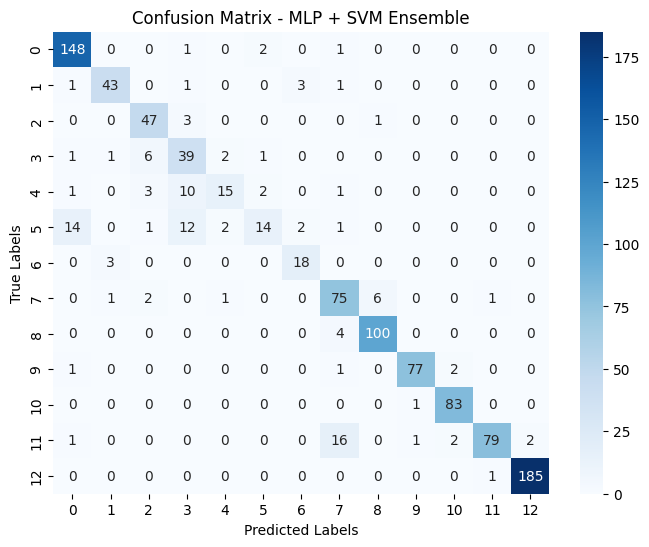

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(Y_test.cpu().numpy().argmax(axis=1), Y_pred_ensemble)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(13), yticklabels=range(13))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - MLP + SVM Ensemble")
plt.show()

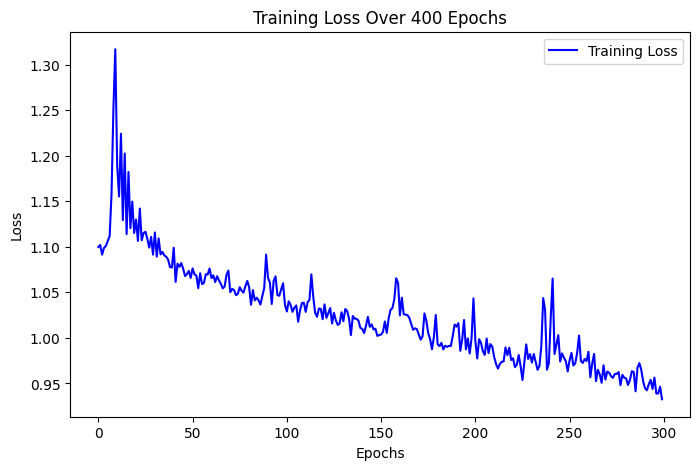

In [ ]:
# Plot Training Loss Over Epochs
plt.figure(figsize=(8, 5))
plt.plot(training_loss, label="Training Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over 400 Epochs")
plt.legend()
plt.show()

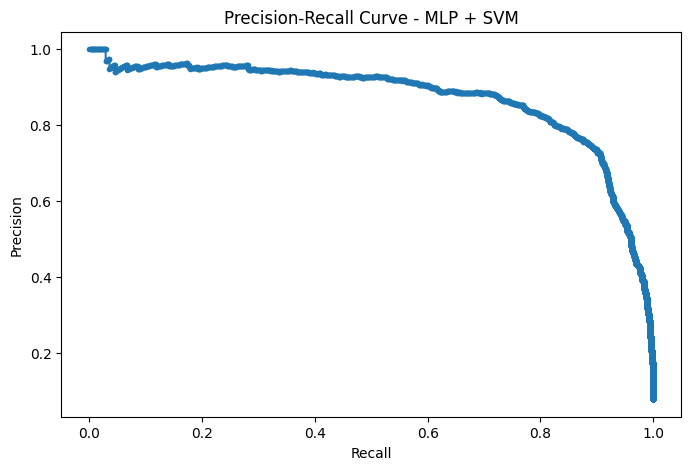

In [ ]:
from sklearn.metrics import precision_recall_curve

# Compute Precision-Recall Curve
precision, recall, _ = precision_recall_curve(Y_test.cpu().numpy().ravel(), Y_pred_mlp.ravel())

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker=".")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - MLP + SVM")
plt.show()